In [1]:
from lightninghw import *
import os
import matplotlib.pyplot as plt
import pickle

In [2]:
symbol = int(64) # read 64 bytes = 32 * 16 bits info

# os.system("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol))
x0 = os.popen("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol)).read()
x0

'00 00 09 00 0b 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 c0 eb 09 00 ff ff 84 02 8e 02 6b 05\n'

Wrote 2 bytes (2800) to config register 0 at addr 0x4
 - Capturing packets at interface ens4f1
Wrote 2 bytes (0100) to config register 0 at addr 0x2
806 packet captured!
processing captured packets...


100%|██████████| 806/806 [00:00<00:00, 14167.99it/s]


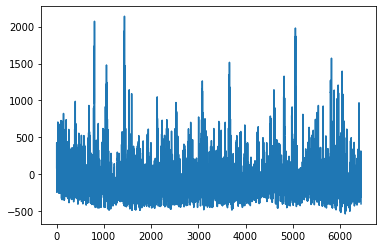

In [12]:
symbol=64
x0 = os.popen("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol)).read()

# eth_read_values = EthernetRead(642, "first_positive", 36)
eth_read_values = EthernetRead(806, "first_negative", 40)

plt.figure()
plt.plot(eth_read_values)
plt.show()

In [13]:
from scipy.fft import fft, ifft, fftfreq

def PrintVectorStream(vector, vector2):
    print("vector.shape:", vector.shape)
    print("Max:", max(vector))
    print("Min:", min(vector))
    
    plt.figure()
    plt.plot(vector, ".", label="Initial voltages")
    plt.plot(vector2, ".", label="Filtered voltages")
    plt.xlabel("Index of vector")
    plt.ylabel("weigth values")
    plt.title("Vector shape")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    diff_vector = [vector[i] - vector2[i] for i in range(len(vector2))]
    plt.figure()
    plt.plot(diff_vector, ".")
    plt.xlabel("Index of vector")
    plt.ylabel("weigth values difference")
    plt.title("Vector difference")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    
def BalunFilter(vector, gsps, min_freq=0.01, max_freq=8):
    vector[:] = [x/max(max(vector), abs(min(vector))) for x in vector]
    n = int(len(vector))
    frequency = fftfreq(n, 1/gsps)
    fft_vector = fft(vector)

    # initial signal spectrum
    plt.figure()
    plt.stem(frequency, abs(fft_vector)/len(vector), linefmt="C0-", markerfmt="C0.", basefmt=None, label="Initial")
    
    # apply balun filter
    for j in range(len(frequency)):
        if abs(frequency[j]) <= min_freq or abs(frequency[j]) >= max_freq:
            fft_vector[j] = 0
    
    plt.stem(frequency, abs(fft_vector)/len(vector), linefmt="C1-", markerfmt="C1.", basefmt=None, label="Filtered")
    plt.title("Signal spectrum")
    plt.xlabel('Freq (GHz)')
    plt.ylabel('|Y(freq)|')
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    # reconstruct the signal
    reconstruct_vector = ifft(fft_vector)
    
    return reconstruct_vector

Calibration function is y = 2.5657698056801195x + 1375.252615844544


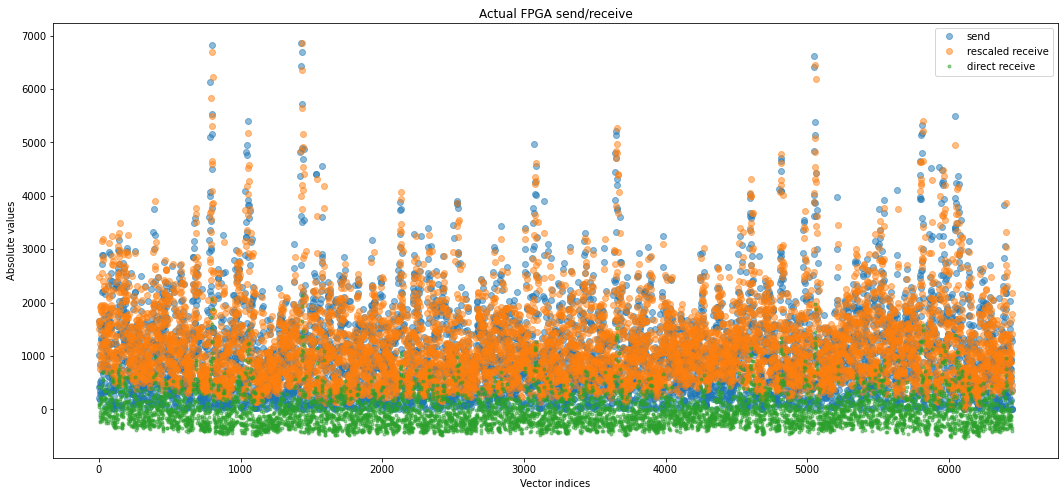

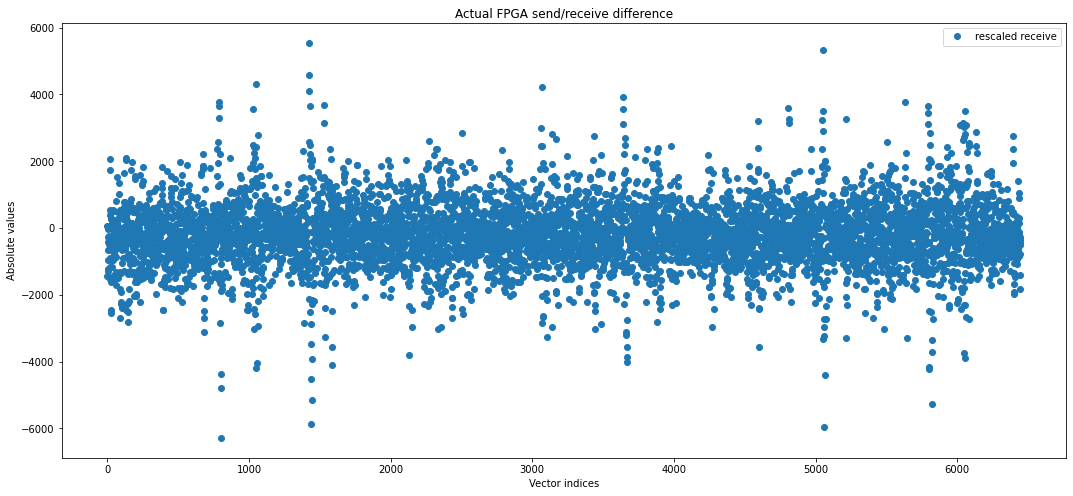

Theoretically, the balun filter effect is like this


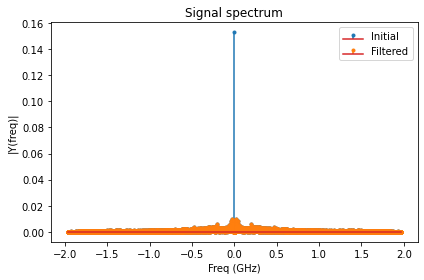

vector.shape: (12896,)
Max: 1.0
Min: 0.0


/home/zhizhenzhong/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


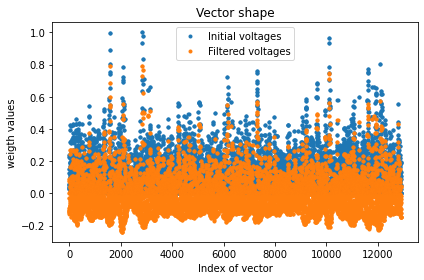

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


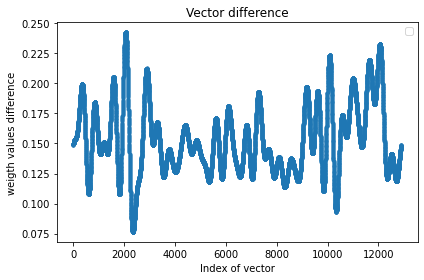

In [14]:
theoretical_data_twice = pickle.load(open("../../fpga/data/lenet/converted_negative_data_1.p", "rb"))
theoretical_data = [theoretical_data_twice[2*i] for i in range(len(theoretical_data_twice)//2)]

revised_eth_read_values = [(x - min(eth_read_values)) for x in eth_read_values]
rescaled_eth_read_values = [x * (max(theoretical_data)/max(revised_eth_read_values)) for x in revised_eth_read_values]

print("Calibration function is y = {}x + {}".format(max(theoretical_data)/max(revised_eth_read_values), max(theoretical_data)/max(revised_eth_read_values)*abs(min(eth_read_values))))
plt.figure(figsize=(18,8))
plt.plot(theoretical_data, label="send", marker="o", linestyle="", alpha=0.5)
plt.plot(rescaled_eth_read_values, label="rescaled receive", marker="o", linestyle="", alpha=0.5)
plt.plot(eth_read_values, label="direct receive", marker=".", linestyle="", alpha=0.5)
plt.title("Actual FPGA send/receive")
plt.xlabel("Vector indices")
plt.ylabel("Absolute values")
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(18,8))
diff = [theoretical_data[i]-rescaled_eth_read_values[i] for i in range(len(rescaled_eth_read_values))]
plt.plot(diff, label="rescaled receive", marker="o", linestyle="")
plt.title("Actual FPGA send/receive difference")
plt.xlabel("Vector indices")
plt.ylabel("Absolute values")
plt.legend(loc="best")
plt.show()

print("Theoretically, the balun filter effect is like this")
filter_theoretical_data_twice = BalunFilter(theoretical_data_twice, 3.93216)
PrintVectorStream(np.array(theoretical_data_twice), np.array(filter_theoretical_data_twice))


In [15]:
import time
from io import StringIO
import sys
import subprocess


# 000 001 001 first layer positive
symbol = int(64) # read 64 bytes = 32 * 16 bits info

# os.system("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol))
x0 = os.popen("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol)).read()
print(x0)

t0 = time.time()

os.system("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --write 0 0x00 0000")  # config_regs[0][15:0]
# os.system("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --write 0 0x04 0a00")  # config_regs[2][15:0]  00001010 | 00000000 -> 0a00

os.system("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --write 0 0x02 0900")  # # config_regs[1][8:0]

# first layer positive: 00 001 001 | 0000000 0 => 0900, first layer positive has 682 cycles
# first layer negative: 00 000 001 | 0000000 0 => 0100, first layer negative has 903 cycles
# second layer positive: 00 010 010 | 0000000 0 => 1200, second layer positive has 77 cycles
# second layer negative: 00 000 010 | 0000000 0 => 0200, second layer negative has 125 cycles
# third layer positive: 00 100 100 | 0000000 0 => 2400, second layer positive has 7 cycles
# third layer negative: 00 000 100 | 0000000 0 => 0400, second layer negative has 1 cycles

# first layer bias: 01 000 000 | 0000000 0 => 4000, first layer negative has 19 cycles
# second layer bias: 10 000 000 | 0000000 0 => 8000, second layer negative has 7 cycles
# third layer bias: 00 000 000 | 0000000 1 => 0001, first layer negative has 1 cycles


## First measurement
x1 = os.popen("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol)).read()
print(x1)

t1 = time.time()
## second measurement
# os.system("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --write 0 0x02 1000")  # write to first register [6:0] idle 000 000 0 [8:0] 000 000 001, negative first layer
x2 = os.popen("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol)).read()
print(x2)

t2 = time.time()
## third measurement
# os.system("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --write 0 0x02 9000")  # write to first register [6:0] idle 000 000 0 [8:0] 000 001 001, positive first layer
x3 = os.popen("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol)).read()
print(x3)

t3 = time.time()
## forth measurement
# os.system("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --write 0 0x02 1000")  # write to first register [6:0] idle 000 000 0 [8:0] 000 000 001, negative first layer
x4 = os.popen("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol)).read()
print(x4)

t4 = time.time()

# print("======python client======")
# print((t1-t0)*1000000, "micro seconds")
# print((t2-t1)*1000000, "micro seconds")
# print((t3-t2)*1000000, "micro seconds")
# print((t4-t3)*1000000, "micro seconds")

def ReadIntFromXFCP(stringset, i):
    timestamps = []
    for x in stringset:
        s = x[-3-6*i:-1-6*i] + x[-6-6*i:-4-6*i]
        a = int('0x'+s, 16)
        timestamps.append(a)

    return timestamps

def ReadHexFromXFCP(stringset, i):
    values = []
    for x in stringset:
        s = x[-3-6*i:-1-6*i] + x[-6-6*i:-4-6*i]
        values.append(s)

    return values

timestamps_2 = ReadIntFromXFCP([x0, x1, x2, x3, x4], 2)
print("Pre DAC cycle counter", timestamps_2)
print("SRAM -> Pre DAC latency (us)", [n/245.76 for n in timestamps_2], "\n")

timestamps_1 = ReadIntFromXFCP([x0, x1, x2, x3, x4], 1)
print("post ADC cycle counter", timestamps_1)
print("SRAM -> Post integration (us)", [n/245.76 for n in timestamps_1], "\n")

timestamps_3 = ReadIntFromXFCP([x0, x1, x2, x3, x4], 3)
print("free counter", timestamps_3)
print("Free counter (us)", [n/245.76 for n in timestamps_3], "\n")

timestamps_0 = ReadIntFromXFCP([x0, x1, x2, x3, x4], 0)
print("post integration", timestamps_0)
print("SRAM -> Post integration (us)", [n/245.76 for n in timestamps_0], "\n")

timestamps_5 = ReadIntFromXFCP([x0, x1, x2, x3, x4], 5)
print("integration output", timestamps_5, "\n")
# print("======FPGA (ADC)======")
# print((a1-a0)*(1/245.76), "micro seconds")
# print((a2-a1)*(1/245.76), "micro seconds")
# print((a3-a2)*(1/245.76), "micro seconds")
# print((a4-a3)*(1/245.76), "micro seconds")


# print("======FPGA (integration)======")
# print((timestamps_1[1]-timestamps_1[0])*(1/245.76), "micro seconds")
# print((a2-a1)*(1/245.76), "micro seconds")
# print((a3-a2)*(1/245.76), "micro seconds")
# print((a4-a3)*(1/245.76), "micro seconds")



00 00 01 00 28 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 c8 c3 01 00 ff ff 28 03 4f 03 42 07

Wrote 2 bytes (0000) to config register 0 at addr 0x0
Wrote 2 bytes (0900) to config register 0 at addr 0x2
00 00 09 00 28 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 b4 cf 09 00 ff ff 84 02 ab 02 88 05

00 00 09 00 28 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 b4 cf 09 00 ff ff 84 02 ab 02 88 05

00 00 09 00 28 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 b4 cf 09 00 ff ff 84 02 ab 02 88 05

00 00 09 00 28 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 

In [16]:

os.system("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --write 0 0x02 0900")  
x0 = os.popen("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol)).read()

os.system("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --write 0 0x02 0100")  
x1 = os.popen("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol)).read()

os.system("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --write 0 0x02 1200")  
x2 = os.popen("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol)).read()

os.system("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --write 0 0x02 0200")  
x3 = os.popen("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol)).read()

os.system("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --write 0 0x02 2400")  
x4 = os.popen("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol)).read()

os.system("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --write 0 0x02 0400")  
x5 = os.popen("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol)).read()

# bias
# os.system("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --write 0 0x02 4000")  
# x6 = os.popen("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol)).read()

# os.system("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --write 0 0x02 8000")  
# x7 = os.popen("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol)).read()

# os.system("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --write 0 0x02 0001")  
# x8 = os.popen("python ../../fpga/lib/xfcp/python/xfcp_ctrl.py --read 0 0x00 {}".format(symbol)).read()


timestamps_2 = ReadIntFromXFCP([x0, x1, x2, x3, x4, x5], 2)
print("Pre DAC cycle counter", timestamps_2)
print("SRAM -> Pre DAC latency (us)", sum([n/245.76 for n in timestamps_2]), " ", [n/245.76 for n in timestamps_2], "\n")

timestamps_1 = ReadIntFromXFCP([x0, x1, x2, x3, x4, x5], 1)
print("post ADC cycle counter", timestamps_1)
print("SRAM -> Post integration (us)", sum([n/245.76 for n in timestamps_1]), " ",[n/245.76 for n in timestamps_1], "\n")

timestamps_0 = ReadIntFromXFCP([x0, x1, x2, x3, x4, x5], 0)
print("post integration", timestamps_0)
print("SRAM -> Post integration (us)", sum([n/245.76 for n in timestamps_0]), " ",[n/245.76 for n in timestamps_0], "\n")

hexvalue_5 = ReadHexFromXFCP([x0, x1, x2, x3, x4, x5], 5)
print("integration output", hexvalue_5)
oracle = ["0x1046", "0xa8ca", "0xb1be", "0x8357", "0x5270", "0x166a"]
print(oracle)
for h in range(len(oracle)):
    print(int(oracle[h], 16), int(hexvalue_5[h], 16))

timestamps_3 = ReadIntFromXFCP([x0, x1, x2, x3, x4, x5], 3)
print("free counter", timestamps_3)
print("Free counter (us)", [n/245.76 for n in timestamps_3], "\n")

Wrote 2 bytes (0900) to config register 0 at addr 0x2
Wrote 2 bytes (0100) to config register 0 at addr 0x2
Wrote 2 bytes (1200) to config register 0 at addr 0x2
Wrote 2 bytes (0200) to config register 0 at addr 0x2
Wrote 2 bytes (2400) to config register 0 at addr 0x2
Wrote 2 bytes (0400) to config register 0 at addr 0x2
Pre DAC cycle counter [644, 808, 58, 107, 8, 3]
SRAM -> Pre DAC latency (us) 6.624348958333333   [2.6204427083333335, 3.287760416666667, 0.23600260416666669, 0.43538411458333337, 0.032552083333333336, 0.01220703125] 

post ADC cycle counter [683, 847, 97, 146, 55, 50]
SRAM -> Post integration (us) 7.6416015625   [2.7791341145833335, 3.446451822916667, 0.3946940104166667, 0.5940755208333334, 0.22379557291666669, 0.20345052083333334] 

post integration [1416, 1858, 206, 302, 74, 62]
SRAM -> Post integration (us) 15.942382812500004   [5.76171875, 7.560221354166667, 0.8382161458333334, 1.2288411458333335, 0.30110677083333337, 0.25227864583333337] 

integration output ['cf